In [1]:
import cv2 as cv ## pip install opencv-python
import matplotlib.pyplot as plt

In [2]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") #weights

In [3]:
inWidth = 368
inHeight = 368
thr = 0.2

In [4]:
# COCO dataset
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

# MPI dataset
# BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
#                    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
#                    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
#                    "Background": 15 }

# POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
#                ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
#                ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
#                ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]

# Hand dataset
# BODY_PARTS = { "Wrist": 0,
#                    "ThumbMetacarpal": 1, "ThumbProximal": 2, "ThumbMiddle": 3, "ThumbDistal": 4,
#                    "IndexFingerMetacarpal": 5, "IndexFingerProximal": 6, "IndexFingerMiddle": 7, "IndexFingerDistal": 8,
#                    "MiddleFingerMetacarpal": 9, "MiddleFingerProximal": 10, "MiddleFingerMiddle": 11, "MiddleFingerDistal": 12,
#                    "RingFingerMetacarpal": 13, "RingFingerProximal": 14, "RingFingerMiddle": 15, "RingFingerDistal": 16,
#                    "LittleFingerMetacarpal": 17, "LittleFingerProximal": 18, "LittleFingerMiddle": 19, "LittleFingerDistal": 20,
#                  }

# POSE_PAIRS = [ ["Wrist", "ThumbMetacarpal"], ["ThumbMetacarpal", "ThumbProximal"],
#                ["ThumbProximal", "ThumbMiddle"], ["ThumbMiddle", "ThumbDistal"],
#                ["Wrist", "IndexFingerMetacarpal"], ["IndexFingerMetacarpal", "IndexFingerProximal"],
#                ["IndexFingerProximal", "IndexFingerMiddle"], ["IndexFingerMiddle", "IndexFingerDistal"],
#                ["Wrist", "MiddleFingerMetacarpal"], ["MiddleFingerMetacarpal", "MiddleFingerProximal"],
#                ["MiddleFingerProximal", "MiddleFingerMiddle"], ["MiddleFingerMiddle", "MiddleFingerDistal"],
#                ["Wrist", "RingFingerMetacarpal"], ["RingFingerMetacarpal", "RingFingerProximal"],
#                ["RingFingerProximal", "RingFingerMiddle"], ["RingFingerMiddle", "RingFingerDistal"],
#                ["Wrist", "LittleFingerMetacarpal"], ["LittleFingerMetacarpal", "LittleFingerProximal"],
#                ["LittleFingerProximal", "LittleFingerMiddle"], ["LittleFingerMiddle", "LittleFingerDistal"] ]

In [17]:
img = cv.imread("image5.jpg")

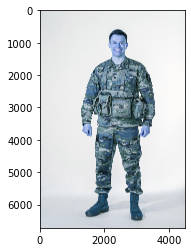

In [18]:
plt.imshow(img) ##BGR - default in opencv

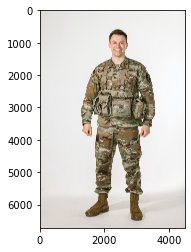

In [19]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)) #Convert it to RGB

In [20]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight= frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0,(inWidth, inHeight), (127.5,127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :] #MobileNet output [01, 57, -1, -1], we only need the first 19 elements
    
    assert(len(BODY_PARTS) == out.shape[1])
    
    points = []## List
    
    for i in range (len(BODY_PARTS)):
        # Slice heatmap of corresponding body’s part.
        heatMap = out[0, i, :, :]
        
        # Originally, we try to find all the local maximus. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it’s confidence is higher than a threshold.
        points.append((int(x), int(y)) if conf > thr else None)
        
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)
        
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        if points[idFrom] and points [idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3) #estimated line configuration in BGR format - current value set to green
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame 

In [21]:
estimated_image = pose_estimation(img)

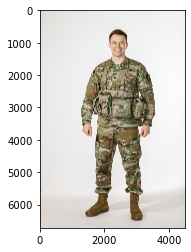

In [22]:
plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))

# For video

In [14]:
cap = cv.VideoCapture('Pose videos/running1.mp4')
cap.set(3,800) #resizing the output
cap.set(3,800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open video")
    
while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight= frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0,(inWidth, inHeight), (127.5,127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :] #MobileNet output [01, 57, -1, -1], we only need the first 19 elements
    
    assert(len(BODY_PARTS) == out.shape[1])
    
    points = []## List
    
    for i in range (len(BODY_PARTS)):
        # Slice heatmap of corresponding body’s part.
        heatMap = out[0, i, :, :]
        
        # Originally, we try to find all the local maximus. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it’s confidence is higher than a threshold.
        points.append((int(x), int(y)) if conf > thr else None)
        
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)
        
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        if points[idFrom] and points [idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3) #estimated line configuration in BGR format - current value set to green
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    cv.imshow('Pose estimation tutorial', frame)

# Real-time webcam

In [65]:
cap = cv.VideoCapture(1)

cap.set(cv.CAP_PROP_FPS, 10)
cap.set(3,800) #resizing the output
cap.set(4,800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight= frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0,(inWidth, inHeight), (127.5,127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :] #MobileNet output [01, 57, -1, -1], we only need the first 19 elements
    
    assert(len(BODY_PARTS) == out.shape[1])
    
    points = []## List
    
    for i in range (len(BODY_PARTS)):
        # Slice heatmap of corresponding body’s part.
        heatMap = out[0, i, :, :]
        
        # Originally, we try to find all the local maximus. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it’s confidence is higher than a threshold.
        points.append((int(x), int(y)) if conf > thr else None)
        
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)

        assert(partTo in BODY_PARTS)
        
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        if points[idFrom] and points [idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3) #estimated line configuration in BGR format - current value set to green
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    cv.imshow('Pose estimation tutorial', frame)